In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
print("Loading training and testing data...")
try:
    train_df = pd.read_csv("training_data.csv")
    test_df = pd.read_csv("testing_data.csv")
    print(f"Successfully loaded training_data.csv (Shape: {train_df.shape})")
    print(f"Successfully loaded testing_data.csv (Shape: {test_df.shape})")
except FileNotFoundError:
    print("Error: training_data.csv or testing_data.csv not found.")
    exit()

Loading training and testing data...
Successfully loaded training_data.csv (Shape: (4400, 32))
Successfully loaded testing_data.csv (Shape: (1100, 32))


In [3]:
target_column = 'prali_fire'

In [4]:
def preprocess_features(df):
    """Applies minimal feature engineering."""
    df = df.copy()
    df['acq_hour'] = df['acq_time'].astype(str).str.zfill(4).str[:2].astype(int)
    return df

print("\nApplying minimal preprocessing...")
train_df_processed = preprocess_features(train_df)
test_df_processed = preprocess_features(test_df)


Applying minimal preprocessing...


In [5]:
new_numeric_features = [
    'brightness', 'scan', 'track', 'confidence', 'bright_t31', 
    'frp', 'type', 'acq_hour', 'NDVI', 'NBR', 'NDWI','acq_time',
]

In [6]:
new_categorical_features = [
    'satellite', 'instrument', 'daynight'
]

In [7]:
all_features = new_numeric_features + new_categorical_features
print(f"Training model with {len(all_features)} features.")

Training model with 15 features.


In [8]:
X_train = train_df_processed[all_features]
y_train = train_df_processed[target_column]

In [9]:
X_test = test_df_processed[all_features]
y_test = test_df_processed[target_column]

print("Preprocessing complete.")

Preprocessing complete.


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [11]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, new_numeric_features),
        ('cat', categorical_transformer, new_categorical_features)
    ])

In [ ]:
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'  
)

In [15]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

In [16]:
print("\nTraining BALANCED Random Forest model...")
pipeline.fit(X_train, y_train)
print("Model training complete.")


Training BALANCED Random Forest model...
Model training complete.


In [ ]:
print("\n--- BALANCED Model Evaluation (No Shortcuts) ---")
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"BALANCED Model Accuracy: {accuracy:.4f} ({(accuracy * 100):.2f}%)")


--- BALANCED Model Evaluation (No Shortcuts) ---
BALANCED Model Accuracy: 0.9482 (94.82%)


In [ ]:

print("\nBALANCED Classification Report:")
report = classification_report(y_test, y_pred)
print(report)


BALANCED Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       842
           1       0.90      0.88      0.89       258

    accuracy                           0.95      1100
   macro avg       0.93      0.92      0.93      1100
weighted avg       0.95      0.95      0.95      1100



Generating BALANCED Confusion Matrix plot...
Saved 'confusion_matrix_balanced.png'


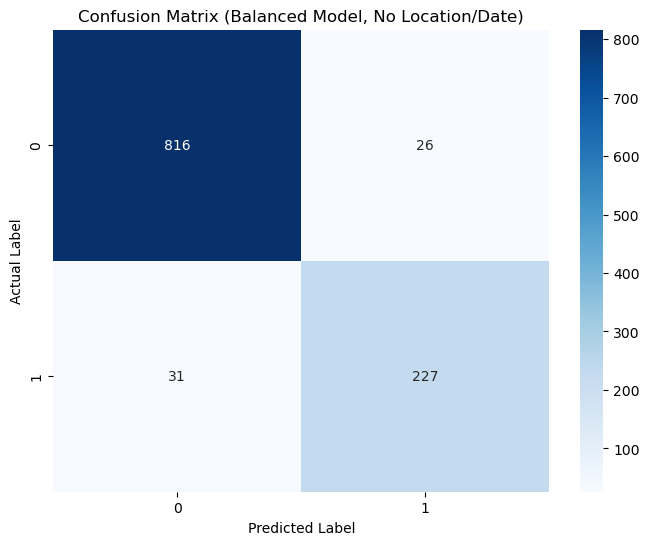

In [19]:
print("Generating BALANCED Confusion Matrix plot...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Balanced Model, No Location/Date)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_balanced.png')
print("Saved 'confusion_matrix_balanced.png'")

Generating BALANCED Feature Importance plot...

Top 10 Most Important Features (Balanced Model):
       feature  importance
4   bright_t31    0.221889
11    acq_time    0.188653
6         type    0.098387
9          NBR    0.071858
7     acq_hour    0.061690
10        NDWI    0.061209
8         NDVI    0.060885
0   brightness    0.059058
2        track    0.045151
5          frp    0.036022


C:\Users\HP\AppData\Local\Temp\ipykernel_4200\3520932707.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


Saved 'feature_importances_balanced.png'

--- All done! ---


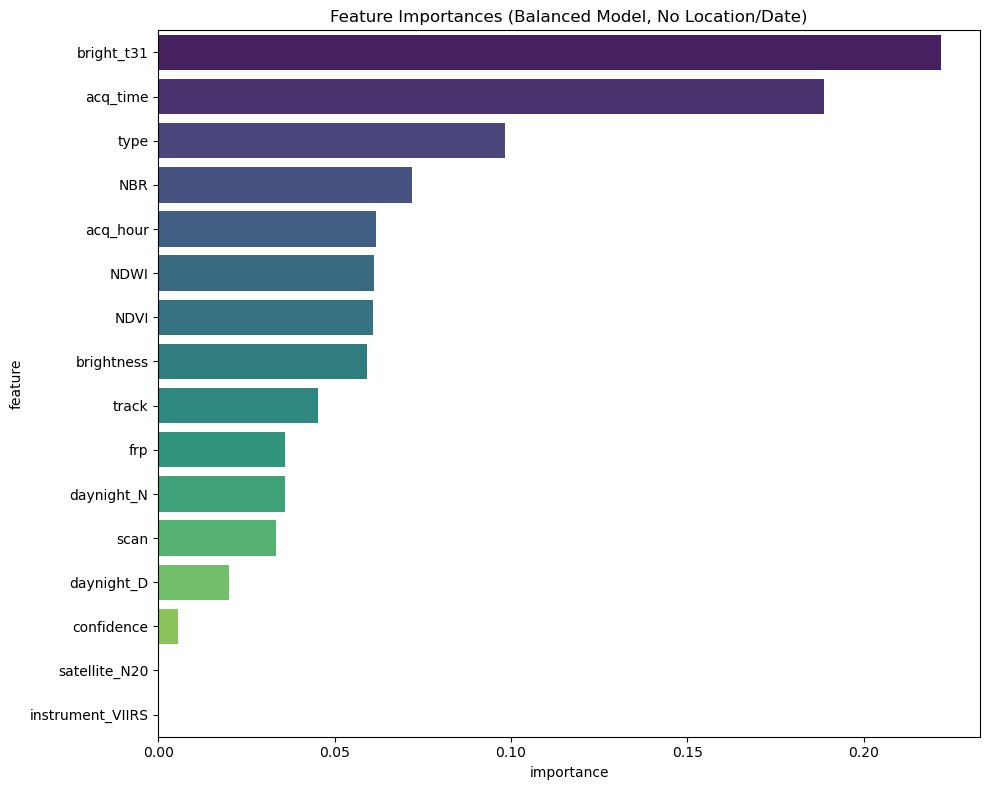

In [ ]:
print("Generating BALANCED Feature Importance plot...")
try:
    ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(new_categorical_features)
    all_feature_names = new_numeric_features + list(ohe_feature_names)

    importances = pipeline.named_steps['classifier'].feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    print("\nTop 10 Most Important Features (Balanced Model):")
    print(feature_importance_df.head(10))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', 
                data=feature_importance_df.head(20), 
                palette='viridis')
    plt.title('Feature Importances (Balanced Model, No Location/Date)')
    plt.tight_layout()
    plt.savefig('feature_importances_balanced.png')
    print("Saved 'feature_importances_balanced.png'")

except Exception as e:
    print(f"Could not plot feature importances: {e}")

print("\n--- All done! ---")